significant trials, significant GT \n
plot trials based on significance or sleep state

In [1]:
import os
import numpy as np
import mne
import imageio
import h5py
# import scipy.fftpack
import matplotlib
import pywt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# from scipy import signal
from matplotlib.colors import ListedColormap
import time
import seaborn as sns

# import scipy.io as sio
# from scipy.integrate import simps
import pandas as pd
# from scipy import fft
import matplotlib.mlab as mlab
import sys
import matplotlib as mpl
sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis\py_functions')
import NMF_funcs as NMFf
import significant_connections as SCF
from scipy.stats import norm
import LL_funcs
from scipy.stats import norm
from tkinter import filedialog
from tkinter import *
import ntpath

root = Tk()
root.withdraw()
import math
import scipy
from scipy import signal
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import platform
from glob import glob
from scipy.io import savemat
import scipy.cluster.hierarchy as spc
from scipy.spatial import distance
from sklearn.cluster import KMeans
import h5py
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
#import IO_func as IOF
#import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
sub_path  ='X:\\4 e-Lab\\' # y:\\eLab
import BM_plots as BMp
import freq_funcs as ff
import CCEP_plot
import supp_CCEP_figures as CCEP_supp
import random
import math
from sklearn.metrics import cohen_kappa_score, jaccard_score, accuracy_score
dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()
color_sleep = ['#808080', '#145da0', '#ff1919']
label_sleep = ['Wake', 'NREM', 'REM']
color_dist = ['0000FF','#0076C4','#00DD91']
import CCEP_func

In [2]:
cond_folder = 'CR'
path_gen_base = sub_path + '\Patients'

In [3]:
plt.rcParams.update({
            'font.family': 'arial',
            'font.size': 12,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'legend.fontsize': 9,
            'svg.fonttype': 'none',
            'font.size': 10,
            'axes.titlesize': 10,
            'axes.labelsize': 8,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'legend.fontsize': 9,
            'figure.titlesize': 10
        })

## Sig connection across

In [5]:
con_summary_all

Stim  Chan         LL     LL_sig      d       Sig  t_WOI        DI  \
0        0     2   8.664564   8.664564   7.00  1.000000  0.000  0.000000   
1        0     6   2.717469   0.605696  21.00  0.160714  0.000 -0.383982   
2        0     7   2.631406   1.235739  24.50  0.454545  0.014 -0.022184   
3        0     8   2.740227   0.618624  28.00  0.183333  0.000  0.000000   
4        0    10   2.022788   0.225311  54.91  0.081967  0.000  0.000000   
...    ...   ...        ...        ...    ...       ...    ...       ...   
1253    61    53   3.094838   0.366979  28.00  0.103448  0.000 -0.453787   
1254    61    54   2.244420   0.635958  24.50  0.241379  0.000 -0.438049   
1255    61    55   5.341371   5.341371  21.00  1.000000  0.000  0.002419   
1256    61    56  10.931035  10.931035  17.50  1.000000  0.000  0.000000   
1257    61    59  23.022260  23.022260   7.00  1.000000  0.000  0.000000   

      delay  Num_sig_trial     Mean_P2P    Mean_LL  
0     0.000           60.0   788.812617   7.163141  
1     0.000            9.0   116.176664   1.682204  
2     0.027           25.0   162.482631   1.512330  
3     0.000           11.0   116.514383   1.252657  
4     0.000            5.0   162.770274   1.803976  
...     ...            ...          ...        ...  
1253  0.027            6.0   178.868354   2.196963  
1254  0.000           14.0   124.316001   1.747567  
1255  0.000           55.0   397.989112   4.545504  
1256  0.000           57.0   969.748390  10.061782  
1257  0.000           58.0  2575.669473  22.584041  

[1258 rows x 12 columns]

In [6]:
subj

'EL010'

In [4]:
subjs = ["EL010", "EL011", "EL012", "EL013", "EL014", "EL015", "EL016", "EL019", "EL020", "EL021",
         "EL022", "EL024", "EL026", "EL027"]
# Initialize arrays for storing predictions and metrics
metrics = {'Subj': [], 'Kappa': [], 'Jaccard': [], 'Accuracy': []}
p_1_all, p_2_all = np.array([]), np.array([])

for subj in subjs:
    path_patient_analysis = os.path.join(sub_path, 'EvM', 'Projects', 'EL_experiment', 'Analysis', 'Patients', subj)
    file_CC_summ = os.path.join(path_patient_analysis, folder, cond_folder, 'data', 'summ_general.csv')
    con_summary_all = pd.read_csv(file_CC_summ)
    con_summary_all = con_summary_all.drop_duplicates()

    p_1 = np.array(con_summary_all.Zscore.values > 6) * 1
    p_2 = np.array(con_summary_all.Sig.values > 0) * 1

    # Calculate Cohen's Kappa and Jaccard Index
    kappa = cohen_kappa_score(p_1, p_2)
    jaccard = jaccard_score(p_1, p_2)
    acc = accuracy_score(p_1, p_2)
    # Store kappa and jaccard values
    metrics['Subj'].append(subj)
    metrics['Kappa'].append(kappa)
    metrics['Jaccard'].append(jaccard)
    metrics['Accuracy'].append(acc)

    # Concatenate prediction values
    p_1_all = np.concatenate([p_1_all, p_1]) if p_1_all.size else p_1
    p_2_all = np.concatenate([p_2_all, p_2]) if p_2_all.size else p_2

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

# Create a figure with 3x1 subplots, where the first subplot is twice as wide
fig, axes = plt.subplots(1, 4,figsize=(8,3), gridspec_kw={'width_ratios': [4, 0.5, 1.5, 1.5]})

# Plotting the confusion matrix
im = axes[0].matshow(confusion_matrix, cmap=plt.cm.Blues)

# Adding labels and titles for the confusion matrix subplot
for (i, j), val in np.ndenumerate(confusion_matrix):
    axes[0].text(j, i, f'{int(val)}', ha='center', va='center', color='black')
axes[0].set_xlabel('Surrogate Method')
axes[0].set_ylabel('Z-score Method')
axes[0].set_title('Agreement between Classifiers across Subject')
axes[0].set_xticks([0, 1], loc = 'bottom')
axes[0].set_box_aspect(1)
# Create an axis for the colorbar in the second subplot
cax = axes[1]#.inset_axes([0, 0, 0.2, 1])  # Adjust the position and width as needed

# Add a colorbar to the second subplot
plt.colorbar(im, cax=cax)
cax.yaxis.set_ticks_position('left')
# axes[1].set_box_aspect(40)

# Second subplot (Jaccard boxplot)
sns.boxplot(y='Accuracy', data=metrics, ax=axes[2],**PROPS)
sns.swarmplot(y='Accuracy', hue='Subj', data=metrics, ax=axes[2], color="grey", edgecolor="black")
axes[2].set_ylim([0, 1])
axes[2].set_title('Accuracy Score')
#axes[2].set_box_aspect(10)

# Third subplot (Cohen's Kappa boxplot)
sns.boxplot(y='Kappa', hue='Subj', data=metrics, ax=axes[3],**PROPS)
sns.swarmplot(y='Kappa', hue='Subj', data=metrics, ax=axes[3], color="grey", edgecolor="black")
axes[3].set_ylim([0, 1])
axes[3].set_title("Cohen's Kappa")
#axes[3].set_box_aspect(10)

# Ensure all axes have the same height
#for ax in axes:
#    ax.set_aspect('auto')

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig('X:\\4 e-Lab\EvM\Projects\EL_experiment\Analysis\Supp_figures\CCEP\CCEP_sigCon_quantification.svg')
# Show the plot
plt.show()

AttributeError: 'DataFrame' object has no attribute 'Zscore'

## Sig. Con. Example single patient

In [102]:
subj = "EL010"
path_patient_analysis = os.path.join(sub_path, 'EvM', 'Projects', 'EL_experiment', 'Analysis', 'Patients', subj)

path_gen = os.path.join(sub_path+'\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_gen, 'Electrodes')
# labels
files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\stimlist_' + cond_folder + '.csv'
stimlist = pd.read_csv(stimlist_file)
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
if "type" in lbls.columns:
    lbls = lbls[lbls.type=='SEEG']
    lbls = lbls.reset_index(drop=True)
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)
stimlist_sleep = pd.read_csv(os.path.join(path_patient_analysis, 'stimlist_hypnogram.csv'))
file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
con_trial = pd.read_csv(file_con)
badchans = pd.read_csv(path_patient_analysis + '/BrainMapping/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1:] == 1))[0, :])

In [103]:
file_CC_summ = path_patient_analysis + '\\' + folder + '\\data\\CC_summ_' + 'similarity' + '.csv'
CC_summ = pd.read_csv(file_CC_summ)


In [104]:
h5_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.h5'
if os.path.isfile(h5_file):
    print('loading h5')
    EEG_resp = h5py.File(h5_file)
    EEG_resp = EEG_resp['EEG_resp']

loading h5


In [105]:
h5_file = path_patient_analysis + '\\' + folder + '\\data\\M_CC_similarity.h5'
if os.path.isfile(h5_file):
    print('loading h5')
    CC = h5py.File(h5_file)
    CC = CC['M_GT_all']

loading h5


In [106]:
h5_file = path_patient_analysis + '\\' + folder + '\\data\\LL_CC_surr_similarity.h5'
if os.path.isfile(h5_file):
    print('loading h5')
    CC_surr = h5py.File(h5_file)
    CC_WOI = CC_surr['CC_WOI']
    CC_surr = CC_surr['CC_LL_surr']
    
h5_file = path_patient_analysis + '\\' + folder + '\\data\\M_CC_similarity.h5'
if os.path.isfile(h5_file):
    print('loading h5')
    CC = h5py.File(h5_file)
    CC = CC['M_GT_all']

loading h5
loading h5


In [107]:
file_CC_summ = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\summ_general.csv'  # summary_genera
con_summary_all = pd.read_csv(file_CC_summ)
con_summary_all = con_summary_all.drop_duplicates()

In [108]:
stop

NameError: name 'stop' is not defined

## SNR

In [152]:
snr_file  = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\SNR_all.csv'  # summary_general
        
table = pd.read_csv(snr_file)

In [153]:
table['Label'] = 'Surr'
table.loc[(table.Real == 1)&(table.Sig==1), 'Label'] = 'Sig'
table.loc[(table.Real == 1)&(table.Sig==0), 'Label'] = 'Non-Sig'


Text(0.5, 0, 'P2P z-scored (based 100 surrogates)')

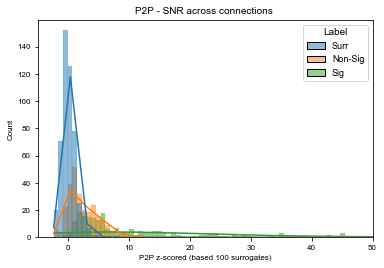

In [157]:
metric = 'P2P'
sns.histplot(table, x=metric+"_SNR", hue="Label", hue_order = ['Surr', 'Non-Sig', 'Sig'],kde=True)
plt.xlim([-5, 50])
plt.title(metric+' - SNR across connections ')
plt.xlabel(metric + ' z-scored (based 100 surrogates)')

In [110]:
con_trial = bf.add_sleepstate(con_trial)

In [34]:
p_val = 0.95

In [126]:
ss = 'Wake'
sc = 8
rc = 60
ylim = 300
sig_trials = con_trial.loc[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.p_value_LL>p_val)&(con_trial.Artefact<1)&(con_trial.SleepState==ss), 'Num'].values
nonsig_trials = con_trial.loc[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.p_value_LL<p_val)&(con_trial.Artefact<1)&(con_trial.SleepState==ss), 'Num'].values


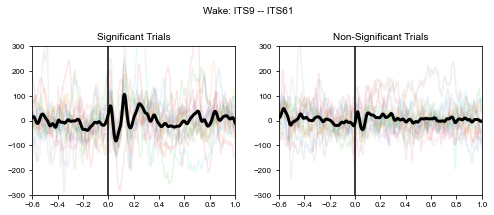

In [127]:

metric = 'p2p'# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
plt.suptitle(ss+ ': '+labels_all[sc]+' -- '+labels_all[rc])
# Plot significant trials
for i in range(len(sig_trials)):
    axs[0].plot(x_ax, EEG_resp[rc, sig_trials[i]], alpha=0.1)
axs[0].plot(x_ax, ff.lp_filter(np.mean(EEG_resp[rc, sig_trials], axis=0), 30, Fs), linewidth=3, label='sig', color='k')
axs[0].set_xlim([-0.6, 1])
axs[0].axvline(0, color=[0, 0, 0])
axs[0].set_title('Significant Trials')
axs[0].set_ylim([-ylim, ylim])

# Plot non-significant trials
for i in range(len(nonsig_trials)):
    axs[1].plot(x_ax, EEG_resp[rc, nonsig_trials[i]], alpha=0.1)
axs[1].plot(x_ax, ff.lp_filter(np.mean(EEG_resp[rc, nonsig_trials], axis=0), 30, Fs), linewidth=3, label='non-sig', color='k')
axs[1].set_xlim([-0.6, 1])
axs[1].axvline(0, color=[0, 0, 0])
axs[1].set_title('Non-Significant Trials')
axs[1].set_ylim([-ylim, ylim])

plt.tight_layout()
plt.show()

In [122]:
table

Stim  Chan  Sig   N  Real         P2P        LL     P2P_SNR     LL_SNR  \
0       0     2    1  60     0   29.142612  0.536821    0.215774   0.218219   
1       0     2    1  60     1  829.961564  7.675622  139.743274  58.576839   
2       0     6    0  47     0   27.890744  0.397908   -0.241807  -1.742858   
3       0     6    0  47     1   54.316265  0.827523    4.489695   0.573793   
4       0     6    1   9     0  105.235751  1.163192    3.424430  -0.710551   
..    ...   ...  ...  ..   ...         ...       ...         ...        ...   
789     8    60    1  27     1  224.629274  2.885362   14.409604  20.505554   
790     8    61    0  43     0   42.516306  0.443469   -0.761251  -1.952395   
791     8    61    0  43     1  136.263446  1.468798    6.241141   0.567797   
792     8    61    1  20     0  101.097015  0.927162    1.002405  -1.045661   
793     8    61    1  20     1  357.562647  4.476351   13.269990   6.627264   

       Label  
0       Surr  
1        Sig  
2       Surr  
3    Non-Sig  
4       Surr  
..       ...  
789      Sig  
790     Surr  
791  Non-Sig  
792     Surr  
793      Sig  

[794 rows x 10 columns]

(0.0, 50.0)

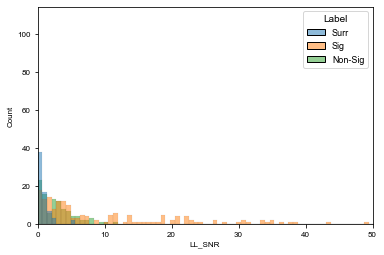

<AxesSubplot:xlabel='P2P_SNR', ylabel='Count'>

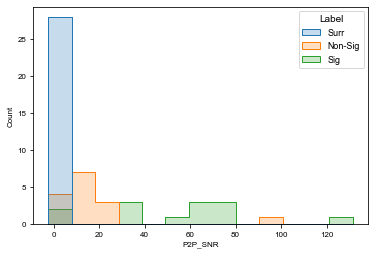

In [98]:
sns.histplot(table, x="P2P_SNR", hue="Label", element="step")

In [47]:
tab_all

Stim  Chan  Sig   N  Real         P2P        LL    P2P_SNR     LL_SNR
0    38    49    0  76     0   16.117572  0.261984  -0.894158  -1.066748
1    38    49    0  76     1   40.321567  0.516802   4.468239   1.405615
2    38    49    1  76     0   18.749828  0.390420  -0.219263   0.527179
3    38    49    1  76     1  157.261595  2.016786  30.569427  22.337228

In [ ]:
sc = 18
rc = 65
p_val = 0.9
sig_trials = con_trial.loc[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.p_value>p_val)&(con_trial.Artefact<1), 'Num'].values

for i in range(len(sig_trials)):
    plt.plot(x_ax, EEG_resp[rc, sig_trials[i]], alpha = 0.1)
plt.plot(x_ax, np.mean(EEG_resp[rc, sig_trials],0), linewidth = 3, label = 'sig', color = 'k')
plt.xlim([-0.6, 1])
plt.axvline(0, color=[0,0,0])
plt.title('sig')
plt.ylim([-ylim, ylim])
plt.show()
nonsig_trials = con_trial.loc[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.p_value<p_val)&(con_trial.Artefact<1), 'Num'].values
for i in range(len(nonsig_trials)):
    plt.plot(x_ax, EEG_resp[rc, nonsig_trials[i]], alpha = 0.1)
plt.plot(x_ax, np.mean(EEG_resp[rc, nonsig_trials],0), linewidth = 3, label = 'non-sig', color = 'k')
plt.xlim([-0.6, 1])
plt.axvline(0, color=[0,0,0])
plt.title('non-sig')
plt.ylim([-ylim, ylim])
plt.show()

In [ ]:
con_trial.loc[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.p_value<0.95)&(con_trial.Artefact<1)]

In [ ]:
sig_trials

## Onset

In [ ]:
def plot_CCEP_onset(EEG_resp, con_trial, labels_all, sc_all, rc_all, CC_summ, w_LL = 0.25, Fs = 500, t0 = 1):
    xlim = [-0.25, 0.5]
    ylim_CCEP = [-350, 350]
    ylim_LL = [0, 8]
    fig, axes = plt.subplots(3, len(sc_all), figsize=(len(sc_all)*2.5, 6))  # Create a 1x3 subplot grid
    fig.patch.set_facecolor('xkcd:white')

    for ix, sc, rc in zip(np.arange(len(sc_all)), sc_all, rc_all):
        lists = con_trial[(con_trial['Chan'] == rc) & (con_trial['Stim'] == sc)& (con_trial['Sig'] == 1)& (con_trial['Artefact'] <1)].reset_index(drop=True)
        stimnum = lists['Num'].values.astype('int')
        data_CCEP = ff.lp_filter(np.mean(EEG_resp[rc, stimnum, :], 0), 30, Fs)
        WOI = CC_summ.loc[(CC_summ.Stim == sc) & (CC_summ.Chan == rc), 't_WOI'].values[0]
        delay, data_LL, d1_LL, d2_LL = CCEP_func.cal_delay(data_CCEP, WOI=WOI)
        #data_CCEP = ff.lp_filter(data_CCEP, 30, Fs)
        pk_CCEP_loc = np.argmax(abs(data_CCEP[int(t0 * Fs):int((t0+WOI+0.125) * Fs)]))
        pk_CCEP = data_CCEP[int(t0*Fs+pk_CCEP_loc)]
        # plot second derivative of LL
        ax = axes[2, ix]
        ax.plot(x_ax + w_LL / 2, d2_LL, linewidth=2, alpha=0.5)
        d2_LL[d1_LL < 0] = np.nan  # only increase intresting
        d2_LL[:int((t0 - w_LL / 2) * Fs)] = np.nan  # not before Stim
        d2_LL[int((t0 * Fs) + pk_CCEP_loc):] = np.nan  # not before Stim
        ax.plot(x_ax + w_LL / 2, d2_LL, linewidth=2)
        pk_loc = np.nanargmax(d2_LL[t0 * Fs:]) / Fs
        pk = np.nanmax(d2_LL[t0 * Fs:])
        ax.plot(pk_loc + w_LL / 2, pk, 'o', color=[0, 1, 0])
        ax.set_xlabel('time [s]')
        ax.set_xticks([0, 0.5])
        if ix == 0:
            ax.set_ylabel('[uV/ms]')
            # ax.set_yticks([0, 3, 6])
        else:
            ax.set_yticks([])
        ax.axvline(0, color=[0, 0, 0])
        ax.set_xlim(xlim)
        ax.set_ylim([-0.03, 0.03])
        ax.set_box_aspect(1.5 / 2)
        # Plot LL
        ax = axes[1, ix]
        ax.plot(x_ax+w_LL/2, data_LL, linewidth=2)
        #ax.set_xlabel('time [s]')
        #ax.set_xticks([0, 0.5])
        if ix ==0:
            ax.set_ylabel('[uV/ms]')
            ax.set_yticks([0, 3, 6])
        else:
            ax.set_yticks([])
        ax.axvline(0, color=[0, 0, 0])
        ax.set_xlim(xlim)
        ax.set_ylim(ylim_LL)
        ax.axvline(pk_loc + w_LL / 2, color=[0, 1, 0])
        ax.set_box_aspect(1.5 / 2)
        # plot orignal data with a shadowd window based on peak LL
        ax = axes[0, ix]
        ax.plot(x_ax, data_CCEP, linewidth=2)
        ax.axvspan(WOI, WOI+0.25, color = [0,0,0], alpha =0.1)
        ax.set_title(labels_all[sc] + ' - ' + labels_all[rc])
        if ix ==0:
            ax.set_ylabel('[uV]')
            ax.set_yticks([-400,0,400])
        else:
            ax.set_yticks([])
        ax.axvline(0, color=[0, 0, 0])
        ax.set_xlim(xlim)
        ax.set_ylim(ylim_CCEP)
        ax.set_xticks([])
        ax.set_box_aspect(1.5 / 2)
        # ax.axvline(pk_loc, color=[0, 1,0])
        ax.axvline(delay, color=[0, 1, 0])
        ax.plot(pk_CCEP_loc/Fs, pk_CCEP, 'o', color=[1, 0, 0])


    return fig, axes

In [ ]:
CCEP_supp.plot_CCEP_onset(EEG_resp, con_trial, labels_all, sc_all, rc_all, CC_summ, w_LL = 0.25, Fs = 500, t0 = 1)

In [ ]:
fig, axes = plt.subplots(1, 4,figsize=(8,3), gridspec_kw={'width_ratios': [4, 0.5, 1.5, 1.5]})

In [ ]:
stop

In [ ]:

example_surr = np.zeros((4, 2))
example_surr[0] = [3, 74]
example_surr[1] = [4, 64] #64
example_surr[2] = [65, 15] #64, [50, 75]
example_surr[3] = [49, 56] #64
example_surr = example_surr.astype('int')

example_z = np.zeros((4, 2))
example_z[0] = [53, 0]
example_z[1] = [53, 76] #64
example_z[2] = [57, 20] #64[54, 68]
example_z[3] = [55, 49] #64
example_z = example_z.astype('int')
# Call the function with your data
fig, axes = CCEP_plot.plot_SigCon_examples(example_z[:,0], example_z[:,1], con_trial, EEG_resp,labels_all, 0)
# plt.savefig('X:\\4 e-Lab\EvM\Projects\EL_experiment\Analysis\Supp_figures\CCEP\CCEP_sigCon_example_zscore.svg')

## LL against distance and delay

In [ ]:
cond_folder ='CR'
folder = 'Brainmapping'

In [ ]:
from scipy import stats

In [ ]:
subjs = ["EL010", "EL011","EL012","EL013", "EL014", "EL015", "EL016", "EL017", "EL019", "EL020", "EL021",
         "EL022", "EL025", "EL026", "EL027", "EL028"]

# subjs = ["EL011","EL012","EL013", "EL014", "EL015", "EL016", "EL017", "EL019"]
start = 1
for subj in subjs:
    for ss in ['Wake', 'NREM', 'REM']:
        path_patient_analysis = os.path.join(sub_path, 'EvM', 'Projects', 'EL_experiment', 'Analysis', 'Patients', subj)
        summary_gen_path = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\summ_' + ss + '.csv'  # summary_general
            
        con_summary_all = pd.read_csv(summary_gen_path)
        con_summary_all = con_summary_all.drop_duplicates()
        con_summary_all['Subj'] = subj
        if start:
            con_all = con_summary_all
            start = 0
        else:
            con_all = pd.concat([con_all, con_summary_all]).reset_index(drop=True)        

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
df = con_all[np.isin(con_all.StimR, regions_all)&(abs(con_all.DI)>0.1)&(con_all.d>20)].reset_index(drop=True)
df = df[['Subj', 'SleepState', 'd', 'DI', 'StimR', 'ChanR']]
    

In [ ]:
from statsmodels.formula.api import ols 
  
# Performing two-way ANOVA 
model = ols('DI ~ C(StimR):C(ChanR)+C(StimR):C(ChanR):C(SleepState) + C(SleepState)+ C(StimR)+ C(ChanR)', data=df).fit() 
sm.stats.anova_lm(model, typ=2) 

In [ ]:
# Define the colors for the custom colormap (dark green, white, gray)
colors = [(0.14117647, 0.52941176, 0.12941176), (1,1,1), (0.2, 0.2, 0.2)]  # R, G, B

# Create the colormap
n_bins = 100  # Increase this number for smoother transitions
cmap_name = 'GreenWhiteGray'
cmap_DI = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


In [ ]:
for ss in ['Wake', 'NREM', 'REM']:
    df = con_all[np.isin(con_all.StimR, regions_all)&(abs(con_all.DI)<1)&(abs(con_all.DI)>0.1)&(con_all.d>20)&(con_all.SleepState ==ss)].reset_index(drop=True)
    df = df[['Subj', 'SleepState', 'd', 'DI', 'StimR', 'ChanR']]
    metric = 'DI'

    # df = con_all[(con_all.SleepState=='Wake')&(con_all.Sig>0)&np.isin(con_all.StimR, regions_all)&np.isin(con_all.ChanR, regions_all)].reset_index(drop=True)
    metric = 'DI'
    cal = 'median'
    grouped_data = df.groupby(['StimR', 'ChanR'])[metric].agg([cal, 'std'])
    # 2. Create a Data Matrix
    data_matrix = pd.DataFrame(index=regions_all, columns=regions_all)
    for (stim, chan), values in grouped_data.iterrows():
        if stim in regions_all and chan in regions_all:
            data_matrix.at[stim, chan] = f"{values[cal]:.2f}\n±{values['std']:.2f}"

    # Reorder data matrix and annotation matrix
    reordered_data = grouped_data[cal].unstack().reindex(index=regions_all, columns=regions_all)
    annot_matrix = data_matrix.reindex(index=regions_all, columns=regions_all)

    # 3. Plot the Heatmap with ordered x-ticks and colorbar limit
    plt.figure(figsize=(8, 5))
    ax = sns.heatmap(reordered_data, annot=annot_matrix,annot_kws={"fontsize":8}, fmt='', cmap=cmap_DI, cbar=True, vmin = -0.5, vmax=0.5)

    # Ensuring the heatmap is square
    ax.set_aspect('equal', 'box')
    # 4. Add titles and labels
    plt.title(ss+': '+cal+' and Standard Deviation of Delays between Brain Regions')
    plt.xlabel('Response Region')
    plt.ylabel('Stimulation Region')
    file = 'X:\\4 e-Lab\EvM\Projects\EL_experiment\Analysis\Supp_figures\Flow\\'+ss+'_'+metric+'_region.svg'
    plt.savefig(file)
    file = 'X:\\4 e-Lab\EvM\Projects\EL_experiment\Analysis\Supp_figures\Flow\\'+ss+'_'+metric+'_region.jpg'
    plt.savefig(file, dpi = 300)
    
plt.show()


In [ ]:
sns.catplot(x='ChanR', y= 'DI', hue='SleepState',row = 'StimR',  data = con_all[np.isin(con_all.StimR, regions_all)&(con_all.d>20)&(con_all.DI>-1)], aspect = 2, palette= color_sleep, kind = 'box', order = regions_all)

In [ ]:
np.percentile(filtered_df['Mean_P2P'], 20)

In [ ]:
# Filter DataFrame for relevant SleepStates
filtered_df = con_all[con_all['SleepState'].isin(['Wake', 'NREM', 'REM'])]

filtered_df = filtered_df[filtered_df.Num_sig_trial>20].reset_index(drop=True)

filtered_df = filtered_df[filtered_df.Mean_LL>1.3].reset_index(drop=True)
filtered_df = filtered_df[filtered_df.Mean_P2P>153].reset_index(drop=True)

# First, calculate the mean delay for each group
grouped = filtered_df.groupby(['Subj', 'Stim', 'Chan', 'SleepState'])['delay'].mean()

# Unstack the SleepState level, which pivots SleepState into columns
unstacked = grouped.unstack(level='SleepState')

# Optionally, rename the columns for clarity
unstacked.columns = [f'delay_{state}' for state in unstacked.columns]

# Reset the index to flatten the DataFrame
final_df = unstacked.reset_index()

final_df['diff'] = abs(final_df['delay_NREM']-final_df['delay_Wake'])
# final_df.loc[(final_df['diff'] >0.05)&(final_df.Subj =='EL011')]

In [ ]:
plt.figure(figsize=(6,6))
final_df = final_df[~np.isnan(final_df.delay_Wake)&~np.isnan(final_df.delay_NREM)].reset_index(drop=True)
# Scatter plot with linear regression line
sns.regplot(x='delay_Wake', y='delay_NREM', data=final_df, line_kws=dict(color="r"), scatter_kws={'s': 10, 'color':'gray'})

# Calculate the linear regression parameters and R^2
slope, intercept, r_value, p_value, std_err = stats.linregress(final_df['delay_Wake'], final_df['delay_NREM'])

# Add R^2 to the plot
plt.text(0.05, 0.95, f'R² = {r_value**2:.2f}', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top')

plt.plot([0,1], [0,1], color=[0,0,0], ls= '--')
plt.xlim([-0.005,0.2])
plt.ylim([-0.005,0.2])

In [ ]:
con_trial = bf.add_sleepstate(con_trial)

In [ ]:
k = -1

In [ ]:
final_df.loc[(final_df['diff'] >0.05)&(final_df.Subj =='EL011')]

In [ ]:
sc = 7
rc = 36
plot_CCEP_onset(EEG_resp, con_trial, labels_all, sc, rc, final_df, Fs = 500, t0 = 1)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_CCEP_onset(EEG_resp, con_trial, labels_all, sc, rc, SS_summ, Fs = 500, t0 = 1):
    w_all = [0.25, 0.05]
    fig, axes = plt.subplots(4+len(w_all), 3, figsize=(14, 8))  # Create a 2x3 subplot grid
    fig.patch.set_facecolor('xkcd:white')
    plt.suptitle(labels_all[sc]+ ' -- '+labels_all[rc])

    # Initialize variables to store the min and max y-values for each row
    row_min_max = [[np.inf, -np.inf] for _ in range(4+len(w_all))]
    
    for ix, ss in enumerate(label_sleep):
        
        lists = con_trial[(con_trial['Chan'] == rc) & (con_trial['Stim'] == sc)& (con_trial['Sig'] == 1)& (con_trial['Artefact'] <1)& (con_trial['SleepState']==ss)].reset_index(drop=True)
        stimnum = lists['Num'].values.astype('int')
        data_CCEP = ff.bp_filter(np.mean(EEG_resp[rc, stimnum, :], 0),2, 30, Fs)
        
        st = np.std(EEG_resp[rc, stimnum, :], 0)

        # Update min and max y-values for each row
        row_min_max[0] = [-300,300]
       

        # CCEP
        ax = axes[0, ix]
        ax.set_title(ss)
        ax.plot(x_ax, data_CCEP, linewidth=2, color=[1, 0, 0.2])
        ax.fill_between(x_ax, data_CCEP-st, data_CCEP+st, alpha=0.1, color=[1, 0, 0])
        ax.axvline(0, color=[0, 0, 0])
        # ax.axvline(delay, color=[0, 1, 0])
        if ix == 0:
            ax.set_ylabel('[uV]')
        else:
            ax.set_yticklabels([])

        # LL
        pk_LL_s = (0.5)
        pk_search_end = 0.5
        for ix_LL, w_LL in enumerate(w_all):
            
            smooth_win = int(w_LL * Fs)
            if np.mod(smooth_win, 2) == 0:
                smooth_win = smooth_win + 1
        
            LL_transform = LL_funcs.get_LL_all(np.expand_dims(data_CCEP, [0, 1]), Fs, w_LL)[0, 0]    
            LL_pk = np.argmax(LL_transform[int((t0-w_LL/2)*Fs):int((t0+pk_search_end+w_LL/2)*Fs)])/Fs#  - 0.75*w_LL
            pk_search_end = np.min([pk_search_end, LL_pk - 0.75*w_LL])
            pk_LL_s = np.min([pk_LL_s, LL_pk - 0.7*w_LL])
            ax = axes[ix_LL+1, ix]
            ax.plot(x_ax + w_LL / 2, LL_transform, linewidth=2, color=[0, 0, 0])
            ax.axvspan(LL_pk- 0.9*w_LL, LL_pk , alpha = 0.1)
            if ix_LL == len(w_all)-1:
                ax.set_xlabel('time [s]')
                #d1_LL = scipy.signal.savgol_filter(LL_transform, smooth_win, 3, 1)  # Second derivative
                d2_LL = scipy.signal.savgol_filter(LL_transform, smooth_win, 3, 2)  # Second derivative
                # d2_LL[int((t0 - w_LL / 2+pk_LL_s) * Fs):] = np.nan 
                
                smooth_win = int(0.051 * Fs)
                if np.mod(smooth_win, 2) == 0:
                    smooth_win = smooth_win + 1
                d2_CCEP = np.zeros(d2_LL.shape)
                d2_CCEP[:-int(w_LL / 2 * Fs)] = abs(scipy.signal.savgol_filter(data_CCEP, smooth_win, 3, 2)[int(w_LL / 2 * Fs):])

            ax.axvline(0, color=[0, 0, 0])
            # ax.axvline(t_onset, color=[1, 0, 0])
            #ax.axvline(w_onset/Fs-1+w_LL/2, color=[1, 0, 1])
            if ix == 0:
                ax.set_ylabel('[uV/ms]')
            else:
                ax.set_yticklabels([])
            row_min_max[ix_LL+1] = [min(row_min_max[ix_LL+1][0], 1.1*np.min(LL_transform[int((t0-0.2-w_LL/2)*Fs):int((t0+0.5-w_LL/2)*Fs)])), max(row_min_max[ix_LL+1][1], 1.1*np.max(LL_transform[int((t0-0.2-w_LL/2)*Fs):int((t0+0.5-w_LL/2)*Fs)]))]
        
        ax = axes[ix_LL+3, ix]
        comb = d2_LL/np.nanmax(d2_LL)
        ax.plot(x_ax + w_LL / 2, comb, linewidth=2, color=[0, 0, 0], alpha =0.1)
        comb[:int((t0 - w_LL / 2) * Fs)] = np.nan
        comb[int((t0 - w_LL / 2+pk_LL_s) * Fs):] = np.nan 
        ax.plot(x_ax + w_LL / 2, comb, linewidth=2, color=[0, 0, 0], label= '2d LL')
        # ax.plot(x_ax + w_LL / 2, d2_CCEP/np.nanmax(d2_CCEP), linewidth=2, color=[1, 0, 0], label= '2d CCEP')
        ax.legend()
        comb = d2_CCEP/np.nanmax(d2_CCEP)  # d2_CCEP/np.nanmax(d2_CCEP)*d2_LL/np.nanmax(d2_LL)
        # thr = 2*np.percentile(comb[int((t0 - w_LL / 2-0.2) * Fs):int((t0 - w_LL / 2-0.01) * Fs)], 99)
        ax.axvline(0, color=[0, 0, 0])
        # d2_CCEP
        row_min_max[ix_LL+2] = [-0.2,1.1]

        
        ax = axes[ix_LL+2, ix]
        ax.axvline(0, color=[0, 0, 0])
        ax.plot(x_ax + w_LL / 2, comb, linewidth=2, color=[1, 0, 0.2], alpha =0.1)
        comb[:int((t0 - w_LL / 2) * Fs)] = np.nan
        comb[int((t0 - w_LL / 2+pk_LL_s) * Fs):] = np.nan 
        ax.plot(x_ax + w_LL / 2, comb, linewidth=2, color=[1, 0, 0.2], label= '2d CCEP')
        ax.legend()
        row_min_max[ix_LL+3] = [-0.2,1.1]
        
        ax = axes[ix_LL+4, ix]
        ax.axvline(0, color=[0, 0, 0])
        comb = comb*d2_LL/np.nanmax(d2_LL)
        ax.plot(x_ax + w_LL / 2, comb, linewidth=2, color=[1, 0, 0], label='2nd LL*CCEP')
        row_min_max[ix_LL+4] = [-0.2,1.1]

        t_onset = np.nanargmax(comb)/Fs-t0+w_LL/2
            # t_onset = peaks[0]/Fs-t0+w_LL/2
        print(t_onset)

        # t_onset = np.nanargmax(comb)
        if t_onset<0:
            t_onset = 0
        
        axes[0, ix].axvline(t_onset, color=[0.1,0.5,0])
        
    # Set y-limits for each row based on the min and max values found
    for row in range(len(w_all)+4):
        for ax in axes[row, :]:
            ax.set_ylim(row_min_max[row])
            ax.set_xlim([-0.1, 1])
    return fig, axes


In [ ]:
def CCEP_onset(data_CCEP, WOI=0, t0=1, Fs=500, w_LL_onset=0.05):
    """
    Calculate the onset of a Cortico-Cortical Evoked Potential (CCEP) in a signal.

    Parameters:
    - signal (array): Mean signal of one connection.
    - WOI (float): Onset of Window Of Interest based on previous LL calculations (connection-specific).
    - t_0 (float): Time of stimulation in the signal (e.g., for epoch: [-1, 3] -> t_0 = 1).
    - Fs (int): Sampling frequency.
    - w_LL_onset (float): Window length for onset detection.

    Returns:
    - float: Time of response onset after stimulation, in seconds.
    """
    data_CCEP_z = zscore_CCEP(data_CCEP, w0=0.1, w1=WOI)

    # Get LL transformation of the filtered signal
    w_LL_short = 0.05
    w_LL_long = 0.25
    pk_LL_s = 0.5
    pk_search_end = 0.5
    # Calculate smoothing window length
    smooth_win = int(w_LL_short * Fs)
    if np.mod(smooth_win, 2) == 0:
        smooth_win += 1

    LL_transform_short = LLf.get_LL_all(np.expand_dims(data_CCEP, [0, 1]), Fs, w_LL_short)[0, 0]
    LL_transform_long = LLf.get_LL_all(np.expand_dims(data_CCEP, [0, 1]), Fs, w_LL_long)[0, 0]
    thr_long = np.percentile(LL_transform_long[int((w_LL_long / 2) * Fs):int((t0 - w_LL_long / 2) * Fs)], 95)
    LL_thr = np.array(
        LL_transform_long[int((t0 - w_LL_long / 2) * Fs):int((t0 - w_LL_long / 2 + 0.5) * Fs)] > thr_long) * 1
    t_resp_all = sf.search_sequence_numpy(LL_thr, np.ones((int(w_LL_long * Fs),)))

    # get loc of LL peak (short and long), keep first peak
    for LL_transform, w_LL, fac in zip([LL_transform_long, LL_transform_short], [w_LL_long, w_LL_short], [0.75, 1]):
        LL_pk = np.argmax(
            LL_transform[int((t0 - w_LL / 2) * Fs):int((t0 + pk_search_end + w_LL / 2) * Fs)]) / Fs  # - 0.75*w_LL
        pk_search_end = np.max([np.min([pk_search_end, LL_pk - fac * w_LL]), 0])
        pk_LL_s = np.max([np.min([pk_LL_s, LL_pk - fac * w_LL]), 0])
    # Find the peak CCEP location
    start_idx = int(t0 * Fs)
    end_idx = int(start_idx + 0.1 * Fs)
    # min and max value of CCEP
    pk_CCEP_loc = 0.5
    # pk_CCEP_loc = np.min([pk_CCEP_loc, (np.nanargmax(data_CCEP[start_idx:end_idx]) + start_idx - int(t0 * Fs)) / Fs])
    # pk_CCEP_loc = np.min([pk_CCEP_loc, (np.nanargmin(data_CCEP[start_idx:end_idx]) + start_idx - int(t0 * Fs)) / Fs])
    thr_pos = np.percentile(data_CCEP_z[int((t0 - 0.1) * Fs):int((t0 - 0.002) * Fs)], 95)
    thr_neg = np.percentile(data_CCEP_z[int((t0 - 0.1) * Fs):int((t0 - 0.002) * Fs)], 5)
    pks_pos, _ = find_peaks(data_CCEP_z[start_idx:end_idx], width=0.01 * Fs, height=2*thr_pos)
    if len(pks_pos) == 0: pks_pos = [250]
    pks_neg, _ = find_peaks(-data_CCEP_z[start_idx:end_idx], width=0.01 * Fs, height=-2*thr_neg)
    if len(pks_neg) == 0: pks_neg = [250]
    # Combine positive and negative peaks
    pk_CCEP_loc = np.min(
        [(pks_pos[0] + start_idx - int(t0 * Fs)) / Fs, (pks_neg[0] + start_idx - int(t0 * Fs)) / Fs, pk_CCEP_loc])
    pk_lim = np.min([pk_CCEP_loc,pk_LL_s])
    # second derivative of LL and CCEP
    d1_LL = scipy.signal.savgol_filter(LL_transform_short, smooth_win, 3, 1)  # Second derivative
    d2_LL = scipy.signal.savgol_filter(LL_transform_short, smooth_win, 3, 2)  # Second derivative
    d2_LL[int((t0 - w_LL_short / 2 + pk_LL_s) * Fs):] = np.nan
    #
    d2_CCEP = np.zeros(d2_LL.shape)
    d2_CCEP[:-int(w_LL_short / 2 * Fs)] = abs(
        scipy.signal.savgol_filter(data_CCEP, smooth_win, 3, 2)[int(w_LL_short / 2 * Fs):])
    CCEP_shift= np.zeros(d2_LL.shape)
    CCEP_shift[:-int(w_LL_short / 2 * Fs)] = data_CCEP_z[int(w_LL_short / 2 * Fs):]

    # Apply constraints to second derivative data
    d1_LL[:int((t0 - w_LL_short / 2) * Fs)] = np.nan  # Ignore values before stimulation
    d2_LL[np.nanargmax(d1_LL):] = np.nan  # before max of d1
    d2_LL[:int((t0 - w_LL_short / 2 - 0.02) * Fs)] = np.nan  # Ignore values before stimulation
    d2_LL[CCEP_shift > 3 * thr_pos] = np.nan  # before CCEP too high
    d2_LL[CCEP_shift < 3 * thr_neg] = np.nan  # before CCEP too high
    d2_LL = d2_LL / np.nanmax(d2_LL)
    d2_CCEP[np.nanargmax(d1_LL):] = np.nan  # before max of d1
    d2_CCEP[:int((t0 - w_LL_short / 2 - 0.02) * Fs)] = np.nan  # Ignore values before stimulation
    d2_CCEP = d2_CCEP / np.nanmax(d2_CCEP)
    comb = d2_LL * d2_CCEP
    comb[0] = -1
    # Find the peak in the second derivative, which indicates the strongest acceleration (response onset)
    peaks, par = find_peaks(comb)
    peaks= peaks[peaks < int((t0 - w_LL_short / 2 + pk_lim) * Fs)]
    if len(peaks) > 0:
        t_onset = peaks[np.argmax(comb[peaks])]/ Fs - t0
        #t_onset = np.nanargmax(comb) / Fs - t0
        t_onset += w_LL_short / 2  # Realign to account for window offset

    else:
        t_onset = np.nanargmax(comb) / Fs - t0
        t_onset += w_LL_short / 2
    # Ensure onset time is not negative
    if t_onset < 0:
        t_onset = 0

    return t_onset

## SNR

In [ ]:
CIRC_AREAS_FILEPATH = 'X:\\4 e-Lab\e-Lab shared code\Softwares\Connectogram\circ_areas.xlsx'
tab_region = pd.read_excel(CIRC_AREAS_FILEPATH, sheet_name='plot')
tab_region = tab_region.sort_values('Order').reset_index(drop=True)
regions_all = tab_region.Area.values
region_col = tab_region.color.values

CIRC_AREAS_FILEPATH = 'X:\\4 e-Lab\e-Lab shared code\Softwares\Connectogram\circ_areas.xlsx'
all_region = pd.read_excel(CIRC_AREAS_FILEPATH, sheet_name='atlas')

In [ ]:
thr = np.percentile(np.max(abs(non_rec_trials[:,:500]),1),99)

In [ ]:
df = con_all[(con_all.SleepState=='Wake') & (con_all.Sig>0) & np.isin(con_all.StimR, regions_all) & np.isin(con_all.ChanR, regions_all)].reset_index(drop=True)


In [ ]:
stim_channels = check_stim_labels(rc, labels_clinic)
stim_num = np.unique(con_trial.loc[np.isin(con_trial.Stim, stim_channels), 'Num'])
rec_trials_num = np.unique(con_trial.loc[(con_trial.Chan == rc) & np.isin(con_trial.Num, stim_num + 1) & (
            con_trial.Artefact < 1), 'Num'])
rec_trials = ff.lp_filter(EEG_resp[rc, rec_trials_num], 1, Fs)
non_rec_trials_num = np.unique(con_trial.loc[(con_trial.Chan == rc) & (~np.isin(con_trial.Num, stim_num + 1)) & (
            con_trial.Artefact < 1), 'Num'])
non_rec_trials = ff.lp_filter(EEG_resp[rc, non_rec_trials_num], 1, Fs)
thr = np.percentile(np.max(abs(non_rec_trials[:,:500]),1),99)
bad_rec = np.where(np.max(abs(rec_trials[:,:500]),1)>thr)


In [ ]:
con_all[con_all.ChanR=='Occipital']

In [ ]:
if len(bad_rec)>0:
    con_trial.loc[(con_trial.Chan == rc)& np.isin(con_trial.Num, rec_trials_num[bad_rec[0]]), 'Artefact'] = 2

In [ ]:
df

In [ ]:
subset

In [ ]:
df = con_all[(con_all.SleepState=='Wake') & (con_all.Sig>0) & np.isin(con_all.StimR, regions_all) & np.isin(con_all.ChanR, regions_all)].reset_index(drop=True)

# Create a grid of subplots
fig, axes = plt.subplots(len(regions_all), len(regions_all), figsize=(15, 15))
fig.patch.set_facecolor('xkcd:white')
# Iterate over each subplot
for i, stim_region in enumerate(regions_all):
    for j, chan_region in enumerate(regions_all):
        # Filter the DataFrame for the current pair of regions
        subset = df[(df['StimR'] == stim_region) & (df['ChanR'] == chan_region)]['delay'].values
        if np.nanmean(subset)>0:
            # Plot histogram in the subplot
            axes[i, j].hist(subset, color='skyblue', edgecolor='black', alpha = 0.5)
            # subset.plot.density(color='r', alpha=1, ax=axes[i, j])
            # Optional: Set title or labels for each subplot if needed
            
        if i == len(regions_all)-1:
            axes[i, j].set_xlabel('Delay ')
        if j == 0:
            axes[i, j].set_ylabel(f'{stim_region}')
        if i == 0:
            axes[i, j].set_title(f'{chan_region}')
            
            
        axes[i, j].set_xlim([0,0.25])
# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
file = 'onset_region_histograms.svg'
plt.savefig(file)

# Show the plot
plt.show()

In [ ]:
df = con_all[(con_all.SleepState=='Wake')&(con_all.Sig>0)&np.isin(con_all.StimR, regions_all)&np.isin(con_all.ChanR, regions_all)].reset_index(drop=True)
grouped_data = df.groupby(['StimR', 'ChanR']).delay.agg(['mean', 'std'])

# 2. Create a Data Matrix
data_matrix = pd.DataFrame(index=regions_all, columns=regions_all)
for (stim, chan), values in grouped_data.iterrows():
    if stim in regions_all and chan in regions_all:
        data_matrix.at[stim, chan] = f"{values['mean']:.2f}\n±{values['std']:.2f}"

# Reorder data matrix and annotation matrix
reordered_data = grouped_data['mean'].unstack().reindex(index=regions_all, columns=regions_all)
annot_matrix = data_matrix.reindex(index=regions_all, columns=regions_all)

# 3. Plot the Heatmap with ordered x-ticks and colorbar limit
fig = plt.figure(figsize=(8, 5))
fig.patch.set_facecolor('xkcd:white')
ax = sns.heatmap(reordered_data, annot=annot_matrix,annot_kws={"fontsize":8}, fmt='', cmap='viridis', cbar=True, vmax=0.1)

# Ensuring the heatmap is square
ax.set_aspect('equal', 'box')
# 4. Add titles and labels
plt.title('Mean and Standard Deviation of Delays between Brain Regions')
plt.xlabel('Response Region')
plt.ylabel('Stimulation Region')
file = 'X:\\4 e-Lab\EvM\Projects\EL_experiment\Analysis\Supp_figures\CCEP\onset_region.svg'
# plt.savefig(file)
plt.show()


In [ ]:
from scipy import stats


In [ ]:
df = con_all[(con_all.SleepState=='Wake')&(con_all.delay<0.31)&(con_all.d>7)&(con_all.Sig>0)].reset_index(drop=True)
plt.figure(figsize=(3,1.25))
# Scatter plot with linear regression line
sns.regplot(x='d', y='delay', data=df, line_kws=dict(color="r"), scatter_kws={'s': 1, 'color':'gray'})

# Calculate the linear regression parameters and R^2
slope, intercept, r_value, p_value, std_err = stats.linregress(df['d'], df['delay'])

# Add R^2 to the plot
plt.text(0.05, 0.95, f'R² = {r_value**2:.2f}', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top')

plt.xlabel('Euclidean Distance [mm]')
plt.ylabel('Response Onset [s]')
plt.title('Across Patients')
plt.xlim([0, 120])
file = 'X:\\4 e-Lab\EvM\Projects\EL_experiment\Analysis\Supp_figures\CCEP\onset_distance.png'
plt.savefig(file, dpi = 300)

In [ ]:
p_value

In [ ]:
color_sleep = ['#808080', '#919FC7', '#ED936B']
label_sleep = ['Wake', 'NREM', 'REM']

In [ ]:
con_all[(con_all.Subj=='EL011')&(con_all.d>20)&(con_all.delay>0.2)]

In [ ]:
metrics = ['LL_sig_mean', 'LL_sig_var']
sleep_states = ['Wake', 'NREM', 'REM']
var_thr = 100
fig, axes = plt.subplots(2, 3, figsize=(8, 5))  # 2x3 subplots

for row, metric in enumerate(metrics):
    for col, ss in enumerate(sleep_states):
        ax = axes[row, col]
        sns.scatterplot(
            x='d', y=metric, 
            data=con_all[(con_all.SleepState == ss) &(con_all.LL_sig_mean < 45)&(con_all.LL_sig_var < var_thr+1) &(con_all['d'] > 7) & (con_all.Sig > 0)], 
            s=2, color=color_sleep[col], ax=ax)

        if row == 1:  # Only show x-label for the last row
            ax.set_xlabel('Euclidean Distance [mm]')
        else:
            ax.set_xlabel('')
            ax.set_xticks([])  # Remove y-ticks

        if col == 0:  # Only show y-label for the first column
            ax.set_ylabel(metric)
        else:
            ax.set_ylabel('')
            ax.set_yticks([])  # Remove y-ticks

        if row == 0:
            ax.set_ylim([0, 45])  # Set the same y-limits for the first row
        elif row == 1:
            ax.set_ylim([0, var_thr+2])  # Set the same y-limits for the second row

        ax.set_title(f'{ss} - {metric}')

plt.suptitle('Across Patients')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the super title
file = 'X:\\4 e-Lab\EvM\Projects\EL_experiment\Analysis\Supp_figures\CCEP\\LL_distance.svg'
plt.savefig(file)

In [ ]:

for m in ['LL_sig_mean', 'LL_sig_var']:
    for ss_ix, ss in enumerate(['Wake', 'NREM', 'REM']):
        plt.figure(figsize=(4,3))
        sns.scatterplot(x = 'd', y= m, data = con_all[(con_all.SleepState==ss)&(con_all.LL_sig_mean<45)&(con_all.LL_sig_var<105)&(con_all.d>7)&(con_all.Sig>0)], s = 2, color = color_sleep[ss_ix])
        plt.xlabel('Euclidean Distance [mm]')

# plt.ylim([0,10])
plt.title('Across Patients')
file = 'X:\\4 e-Lab\EvM\Projects\EL_experiment\Analysis\Supp_figures\CCEP\\'+m+'_distance.svg'
plt.savefig(file)

In [ ]:
sns.scatterplot(x = 'd', y= 'LL_var',data = con_all[(con_all.LL_mean<45)&(con_all.LL_var<200)&(con_all.d>7)&(con_all.Sig>0)])

In [ ]:
sns.scatterplot(x = 'd', y= 'LL_mean', data = con_all[(con_all.LL_var<200)&(con_all.LL_mean<45)&(con_all.d>7)&(con_all.Sig>0)])

# CCEP magnitude (single trial)

In [ ]:
subj = 'EL027'
path_patient_analysis = os.path.join(sub_path, 'EvM', 'Projects', 'EL_experiment', 'Analysis', 'Patients', subj)
file_CC_summ = os.path.join(path_patient_analysis, folder, cond_folder, 'data', 'summ_general.csv')
file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
con_trial = pd.read_csv(file_con)


In [ ]:
h5_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.h5'
if os.path.isfile(h5_file):
    print('loading h5')
    EEG_resp = h5py.File(h5_file)
    EEG_resp = EEG_resp['EEG_resp']

In [ ]:
data_list = con_trial[(con_trial.Artefact<1)&(con_trial.LL>50)&(con_trial.Sig==1)].reset_index(drop=True)

In [ ]:
k = -1

In [ ]:
k = k+1
rc = data_list.Chan.values[k]
sc =  data_list.Stim.values[k]
trial = data_list.Num.values[k]
trial_all = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim == sc), 'Num'].values
plt.plot(x_ax, EEG_resp[rc,trial], color = 'b', alpha = 0.8, lw = 4)
plt.plot(x_ax, np.mean(EEG_resp[rc,trial_all, :],0), color = 'k', alpha = 0.5, lw = 2)
plt.axvline(0)
plt.axvspan(0.01, 0.05, alpha= 0.1, color = color_elab[0])
plt.axvspan(0.05, 0.4, alpha= 0.1, color = color_elab[2])
plt.xlim([-0.5, 1])

In [ ]:
print(sc, rc, trial)

In [ ]:
18, 14, 63 # delay
3 37 70 # N1 negative
19 45 2 # no cleat N1
6 14 9 # strong AUC
6 55 9 # strong AUC, negative N2
36 14 11 # good

In [ ]:
trials = [11, 9, 2, 70, 63]
sc_all = [36, 6, 19, 3, 18]
rc_all = [14, 55, 45, 37, 14]

In [ ]:
# Create a figure with one row and as many columns as len(trials)
fig, axes = plt.subplots(1, len(trials), figsize=(len(trials) * 5, 5))

for ix, ax in enumerate(axes):
    sc = sc_all[ix]
    rc = rc_all[ix]
    trial = trials[ix]

    trial_all = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim == sc), 'Num'].values
    ax.plot(x_ax, EEG_resp[rc, trial], color='k', alpha=1, lw=2)

    mean = np.mean(EEG_resp[rc, trial_all, :], 0)
    mean = CCEP_func.zscore_CCEP(mean)
    pol = -1 if abs(np.min(mean[int((t0 + 0.01) * Fs):int((t0 + 0.05) * Fs)])) > np.max(
                mean[int((t0 + 0.01) * Fs):int((t0 + 0.05) * Fs)]) else 1

    N1_loc = np.argmax(pol * EEG_resp[rc, trial, int((t0 + 0.01) * Fs):int((t0 + 0.05) * Fs)]) / Fs + 0.01
    N2_loc = np.argmax(pol * EEG_resp[rc, trial, int((t0 + 0.05) * Fs):int((t0 + 0.4) * Fs)]) / Fs + 0.05
    N1 = np.max(pol * EEG_resp[rc, trial, int((t0 + 0.01) * Fs):int((t0 + 0.05) * Fs)])
    N2 = np.max(pol * EEG_resp[rc, trial, int((t0 + 0.05) * Fs):int((t0 + 0.4) * Fs)])
    LL = con_trial.loc[(con_trial.Chan == rc) & (con_trial.Num == trial), 'LL'].values[0]
    AUC = con_trial.loc[(con_trial.Chan == rc) & (con_trial.Num == trial), 'AUC'].values[0]

    ax.plot(N1_loc, pol*N1, 'ro', markersize=5)
    ax.plot(N2_loc, pol*N2, 'ro', markersize=5)

    ax.plot(x_ax, mean, color='k', alpha=0.5, lw=2, ls='--')
    ax.fill_between(x_ax_AUC, EEG_resp[rc, trial, int(t0 * Fs):int((t0 + 1) * Fs)], alpha=0.1)
    ax.axvline(0)
    ax.axvspan(0.01, 0.05, alpha=0.1, color=color_elab[0])
    ax.axvspan(0.05, 0.4, alpha=0.1, color=color_elab[2])
    loc_max = np.argmax(EEG_resp[rc, trial, int(t0 * Fs):int((t0 + 1) * Fs)]) / Fs
    mx = np.max(EEG_resp[rc, trial, int(t0 * Fs):int((t0 + 1) * Fs)])
    mn = np.min(EEG_resp[rc, trial, int(t0 * Fs):int((t0 + 1) * Fs)])
    P2P = mx - mn
    ax.vlines(loc_max, ymin=mn, ymax=mx, color='r', zorder=2)
    ax.set_xlim([-0.25, 1.2])
    ax.set_ylim([-800, 600])
    ax.set_title(labels_all[sc] + ' -- ' + labels_all[rc])
    ax.text(0.8, -300, f'LL = {LL:.2f}\nAUC = {AUC:.0f}\nP2P = {P2P:.0f}\nN1 = {N1:.1f}\nN2 = {N2:.1f}', ha='left', va='top')

plt.tight_layout()
plt.savefig('X:\\4 e-Lab\EvM\Projects\EL_experiment\Analysis\Supp_figures\CCEP\CCEP_magnitude_examples.svg')
plt.show()


In [ ]:
sc = sc_all[ix]
rc = rc_all[ix]
trial = trials[ix]

trial_all = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim == sc), 'Num'].values
plt.plot(x_ax, EEG_resp[rc,trial], color = 'k', alpha = 1, lw = 2)
mean = np.mean(EEG_resp[rc,trial_all, :],0)
mean = CCEP_func.zscore_CCEP(mean)
pol = -1 if abs(np.min(mean[int((t0 + 0.01) * Fs):int((t0 + 0.05) * Fs)])) > np.max(
            mean[int((t0 + 0.01) * Fs):int((t0 + 0.05) * Fs)]) else 1

N1_loc = np.argmax(pol * EEG_resp[rc,trial, int((t0 + 0.01) * Fs):int((t0 + 0.05) * Fs)])/Fs+0.01
N2_loc = np.argmax(pol * EEG_resp[rc,trial, int((t0 + 0.05) * Fs):int((t0 + 0.4) * Fs)])/Fs+0.05
N1 = np.max(pol * EEG_resp[rc,trial, int((t0 + 0.01) * Fs):int((t0 + 0.05) * Fs)])
N2 = np.max(pol * EEG_resp[rc,trial, int((t0 + 0.05) * Fs):int((t0 + 0.4) * Fs)])
LL = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Num == trial), 'LL'].values[0]
AUC = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Num == trial), 'AUC'].values[0]

plt.plot(N1_loc,N1, 'ro' , markersize = 5)
plt.plot(N2_loc,N2, 'ro' , markersize = 5)

    
plt.plot(x_ax, mean, color = 'k', alpha = 0.5, lw = 2, ls = '--')
plt.fill_between(x_ax_AUC, EEG_resp[rc,trial, int(t0*Fs):int((t0+1)*Fs)], alpha =.1)
plt.axvline(0)
plt.axvspan(0.01, 0.05, alpha= 0.1, color = color_elab[0])
plt.axvspan(0.05, 0.4, alpha= 0.1, color = color_elab[2])
loc_max = np.argmax(EEG_resp[rc,trial, int(t0*Fs):int((t0+1)*Fs)])/Fs
mx = np.max(EEG_resp[rc,trial, int(t0*Fs):int((t0+1)*Fs)])
mn  = np.min(EEG_resp[rc,trial, int(t0*Fs):int((t0+1)*Fs)])
P2P = mx-mn
plt.vlines(loc_max,ymin=mn, ymax = mx, color = 'r', zorder=2)
plt.xlim([-0.25, 1.2])
plt.ylim([-600,600])
plt.title(labels_all[sc]+ ' -- '+labels_all[rc])
plt.text(0.8, -300, f'LL = {LL:.2f}\nAUC = {AUC:.0f}\nP2P = {P2P:.0f}\nN1 = {N1:.1f}\nN2 = {N2:.1f}',ha='left', va='top')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

from scipy.optimize import curve_fit

In [ ]:
for subj in subjs:
    path_patient_analysis = os.path.join(sub_path, 'EvM', 'Projects', 'EL_experiment', 'Analysis', 'Patients', subj)
    file_CC_summ = os.path.join(path_patient_analysis, folder, cond_folder, 'data', 'summ_general.csv')
    file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
    con_trial = pd.read_csv(file_con)
    con_trial = con_trial[(con_trial.P2P <4000)&(con_trial.Artefact < 1)&(con_trial.Sig == 1)].reset_index(drop=True)
    con_trial = con_trial[['LL','AUC', 'P2P', 'P2P_1s','N1', 'N2','d']]
    if subj == subjs[0]:
        con_trial_all = con_trial
    else:
        con_trial_all = pd.concat([con_trial_all, con_trial])

In [ ]:

metrics = ['AUC', 'P2P_1s', 'N1', 'N2']
metric_x = 'LL'

# Filter significant connections
subset = con_trial_all[con_trial_all.LL<35.1].reset_index(drop=True)
# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for m_ix, m in enumerate(metrics):
    ax = axes[m_ix]
    
    # Scatter plot a random 5% subset of the data points
    sample_subset = subset.sample(frac=0.0001)
    ax.scatter(sample_subset[metric_x], sample_subset[m], alpha=0.5, edgecolors='k', facecolor ='w')

    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset[metric_x], subset[m])

    # Generate regression line x and y values
    x = np.linspace(subset[metric_x].min(), subset[metric_x].max(), 100)
    y = intercept + slope * x

    # Plot the regression line
    ax.plot(x, y, color=color_elab[0], linewidth = 5)

    # Add R² and standard error to the plot
    r_squared = r_value ** 2
    ax.text(0.05, 0.95, f'R² = {r_squared:.2f}\nStd Err = {std_err:.2f}', 
            transform=ax.transAxes, ha='left', va='top')
    if p_value<0.01:
        ax.text(0.85, 0.95, '***', 
            transform=ax.transAxes, ha='right', va='top', fontsize = 30)
    elif p_value<0.05:
        ax.text(0.85, 0.95, '*', 
            transform=ax.transAxes, ha='right', va='top', fontsize = 30)
    ax.set_title(f'Regression of {m} vs {metric_x}')
    ax.set_ylabel('[uV]')
    if m_ix>1:
        ax.set_xlabel('LL [uV]')

plt.tight_layout()

plt.savefig('X:\\4 e-Lab\EvM\Projects\EL_experiment\Analysis\Supp_figures\CCEP\CCEP_magnitude_linReg_2.svg')
plt.show()
